# LGBMRegressor를 이용한 삼성전자의 다음날 종가&상승or하락 예측

1990년 1월 1일부터 2022년 12월 31일의 데이터로 2023년의 삼성전자 주가를 예측합니다.

In [1]:
!pip install finance-datareader

FinanceDataReader 라이브러리로 1990년 1월 1일부터 2023년 8월 4일까지의 삼성전자 주가 데이터를 불러옵니다.

먼저, 직전 몇 거래일 동안의 데이터로 다음날 종가를 예측할지 결정합니다.
<br>
<br>
이를 위해, 5~200일 중 가장 결정계수 값이 높은 수를 찾습니다.

35개의 직전 거래일 데이터를 사용하는 것이 가장 결정계수값이 높았습니다.
<br>
<br>
이제 모델을 학습해보겠습니다.

In [2]:
import FinanceDataReader as fdr

df = fdr.DataReader('005930')
df['Next_Day_Direction'] = df['Close'].shift(-1) - df['Close']

# 'Next_Day_Direction' 값을 '상승', '하락'으로 변환
df['Next_Day_Direction'] = df['Next_Day_Direction'].apply(lambda x: 'Up' if x >= 0 else 'Down')
df = df.iloc[:-1]

# 결과 출력
print(df)

             Open   High    Low  Close    Volume    Change Next_Day_Direction
Date                                                                         
1999-04-27   1976   2035   1907   1925   1090788       NaN                 Up
1999-04-28   1917   1954   1909   1925    608370  0.000000               Down
1999-04-29   1917   1917   1819   1820    739553 -0.054545               Down
1999-04-30   1817   1817   1757   1788   1128711 -0.017582               Down
1999-05-03   1798   1800   1770   1785    435785 -0.001678               Down
...           ...    ...    ...    ...       ...       ...                ...
2023-07-31  70900  71000  69800  69800  13035420 -0.011331                 Up
2023-08-01  70100  71200  70000  71100  12299254  0.018625               Down
2023-08-02  70700  71000  69800  69900  13835020 -0.016878               Down
2023-08-03  69900  70200  68500  68800  20087090 -0.015737               Down
2023-08-04  68800  69100  68200  68300  12360193 -0.007267      

In [3]:
# 이동평균을 계산하는 함수를 정의합니다.
def calculate_moving_average(df, column, window):
    return df[column].rolling(window=window).mean()

# 여러 이동평균 기간을 설정합니다.
moving_average_periods = [5, 10, 20, 60, 120, 240]

# 이동평균을 구하고 데이터 프레임에 새 열로 추가합니다.
for period in moving_average_periods:
    column_name = f"MA_{period}"
    df[column_name] = calculate_moving_average(df, 'Close', period)

In [4]:
# 이동표준편차를 계산하는 함수를 정의합니다.
def calculate_moving_std(df, column, window):
    return df[column].rolling(window=window).std()

# 볼린저 밴드를 계산하는 함수를 정의합니다.
def calculate_bollinger_bands(df, column, window):
    MA = calculate_moving_average(df, column, window)
    STD = calculate_moving_std(df, column, window)
    return MA - 2 * STD, MA + 2 * STD

# 볼린저 밴드 기간을 설정합니다.
bollinger_band_period = 20

# 볼린저 밴드를 계산합니다.
df['BB_Lower'], df['BB_Upper'] = calculate_bollinger_bands(df, 'Close', bollinger_band_period)

In [5]:
# RSI를 계산하는 함수를 정의합니다.
def calculate_rsi(df, column, window=14):
    delta = df[column].diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0

    # Wilder's exponential moving average
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = abs(loss.ewm(com=window - 1, min_periods=window).mean())

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# RSI 기간을 설정합니다. 일반적으로 14일을 사용합니다.
rsi_period = 14

# RSI를 계산합니다.
df['RSI'] = calculate_rsi(df, 'Close', rsi_period)

In [6]:
# 지수이동평균(EMA)을 계산하는 함수를 정의합니다.
def calculate_ema(df, column, window):
    return df[column].ewm(span=window).mean()

# MACD를 계산하는 함수를 정의합니다.
def calculate_macd(df, column, short_window=12, long_window=26):
    short_ema = calculate_ema(df, column, short_window)
    long_ema = calculate_ema(df, column, long_window)
    return short_ema - long_ema

# MACD 시그널을 계산하는 함수를 정의합니다.
def calculate_macd_signal(df, column, macd_window=9):
    return df[column].ewm(span=macd_window).mean()

# MACD를 계산합니다.
df['MACD'] = calculate_macd(df, 'Close')

# MACD 시그널을 계산합니다.
df['MACD_Signal'] = calculate_macd_signal(df, 'MACD')

In [7]:
import pandas as pd

# True Range를 계산하는 함수를 정의합니다.
def calculate_true_range(df, high_col='High', low_col='Low', close_col='Close'):
    high_low = df[high_col] - df[low_col]
    high_close = df[high_col] - df[close_col].shift(1)
    low_close = df[low_col] - df[close_col].shift(1)
    ranges = pd.concat([high_low, high_close.abs(), low_close.abs()], axis=1)
    true_range = ranges.max(axis=1)
    return true_range

# +DMI, -DMI를 계산하는 함수를 정의합니다.
def calculate_dm(df, high_col='High', low_col='Low'):
    up_move = df[high_col] - df[high_col].shift(1)
    down_move = df[low_col].shift(1) - df[low_col]

    plus_dm = pd.Series(index=df.index)
    minus_dm = pd.Series(index=df.index)

    for i in range(len(df)):
        if up_move[i] > down_move[i] and up_move[i] > 0:
            plus_dm.iloc[i] = up_move[i]
        else:
            plus_dm.iloc[i] = 0
        if down_move[i] > up_move[i] and down_move[i] > 0:
            minus_dm.iloc[i] = down_move[i]
        else:
            minus_dm.iloc[i] = 0

    return plus_dm, minus_dm

# ADX를 계산하는 함수를 정의합니다.
def calculate_adx(df, window=14, high_col='High', low_col='Low', close_col='Close'):
    true_range = calculate_true_range(df)
    plus_dm, minus_dm = calculate_dm(df)

    atr = true_range.rolling(window=window).sum() / window
    plus_di = 100 * (plus_dm.rolling(window=window).sum() / atr)
    minus_di = 100 * (minus_dm.rolling(window=window).sum() / atr)

    dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
    adx = dx.rolling(window=window).mean()

    return adx

# ADX를 계산합니다.
df['ADX'] = calculate_adx(df)

<ipython-input-7-712ef8006972>:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  plus_dm = pd.Series(index=df.index)
<ipython-input-7-712ef8006972>:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  minus_dm = pd.Series(index=df.index)


In [8]:
# 전환선 (Conversion Line)를 계산하는 함수를 정의합니다.
def calculate_conversion_line(df, high_col='High', low_col='Low', n1=9):
    high_n1 = df[high_col].rolling(window=n1).max()
    low_n1 = df[low_col].rolling(window=n1).min()
    conversion_line = (high_n1 + low_n1) / 2
    return conversion_line

# 기준선 (Base Line)를 계산하는 함수를 정의합니다.
def calculate_base_line(df, high_col='High', low_col='Low', n2=26):
    high_n2 = df[high_col].rolling(window=n2).max()
    low_n2 = df[low_col].rolling(window=n2).min()
    base_line = (high_n2 + low_n2) / 2
    return base_line

# 선행 스팬 A를 계산하는 함수를 정의합니다.
def calculate_leading_span_A(conversion_line, base_line):
    leading_span_A = (conversion_line + base_line) / 2
    return leading_span_A

# 선행 스팬 B를 계산하는 함수를 정의합니다.
def calculate_leading_span_B(df, high_col='High', low_col='Low', n3=52):
    high_n3 = df[high_col].rolling(window=n3).max()
    low_n3 = df[low_col].rolling(window=n3).min()
    leading_span_B = (high_n3 + low_n3) / 2
    return leading_span_B

# 전환선 (Conversion Line) 계산
df['Conversion_Line'] = calculate_conversion_line(df)

# 기준선 (Base Line) 계산
df['Base_Line'] = calculate_base_line(df)

# 선행 스팬 A 계산
df['Leading_Span_A'] = calculate_leading_span_A(df['Conversion_Line'], df['Base_Line'])

# 선행 스팬 B 계산
df['Leading_Span_B'] = calculate_leading_span_B(df)

In [9]:
import numpy as np

# 각 column에 0 몇개인지 확인
for col in df.columns:
    missing_rows = df.loc[df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))
df['Volume'] = df['Volume'].replace(0, np.nan)
df = df.dropna()
print()
df.isnull().sum()

# 결과를 출력합니다.
df

Open: 3
High: 3
Low: 3
Close: 0
Volume: 3
Change: 223
Next_Day_Direction: 0
MA_5: 0
MA_10: 0
MA_20: 0
MA_60: 0
MA_120: 0
MA_240: 0
BB_Lower: 0
BB_Upper: 0
RSI: 0
MACD: 2
MACD_Signal: 2
ADX: 0
Conversion_Line: 0
Base_Line: 0
Leading_Span_A: 0
Leading_Span_B: 0



,Open,High,Low,Close,Volume,Change,Next_Day_Direction,MA_5,MA_10,MA_20,...,BB_Lower,BB_Upper,RSI,MACD,MACD_Signal,ADX,Conversion_Line,Base_Line,Leading_Span_A,Leading_Span_B
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-10,7499,7499,7200,7300,717709.0,0.013889,Down,7016.0,7032.0,6386.5,...,4821.040256,7951.959744,63.236128,423.306228,378.489203,56.848443,7164.5,6400.0,6782.25,6230.0
2000-04-11,7200,7200,6950,7100,581565.0,-0.027397,Down,7016.0,7062.0,6482.5,...,4995.024215,7969.975785,59.794945,413.828704,385.557104,57.749968,7164.5,6400.0,6782.25,6230.0
2000-04-12,6960,7030,6860,6910,705096.0,-0.026761,Down,7038.0,7050.0,6567.5,...,5196.463128,7938.536872,56.641498,386.530602,385.751803,58.614624,7104.5,6400.0,6752.25,6230.0
2000-04-14,6600,6680,6260,6260,1247397.0,-0.094067,Down,6954.0,6910.0,6610.5,...,5343.651860,7877.348140,47.426654,308.886441,370.378731,57.609787,6879.5,6400.0,6639.75,6230.0
2000-04-17,5420,5750,5340,5520,1561048.0,-0.118211,Up,6618.0,6757.0,6616.5,...,5372.867375,7860.132625,39.539997,185.502709,333.403526,55.643670,6419.5,6400.0,6409.75,6230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,70900,71000,69800,69800,13035420.0,-0.011331,Up,70380.0,70730.0,71265.0,...,68871.785909,73658.214091,43.420078,-205.213820,29.627246,14.611389,70450.0,70850.0,70650.00,69200.0
2023-08-01,70100,71200,70000,71100,12299254.0,0.018625,Down,70600.0,70640.0,71170.0,...,68920.228082,73419.771918,50.345440,-168.714644,-10.041132,15.739209,70250.0,70850.0,70550.00,69650.0
2023-08-02,70700,71000,69800,69900,13835020.0,-0.016878,Down,70620.0,70460.0,71065.0,...,68782.549793,73347.450207,44.884145,-233.922246,-54.817355,17.462444,70250.0,70850.0,70550.00,70550.0


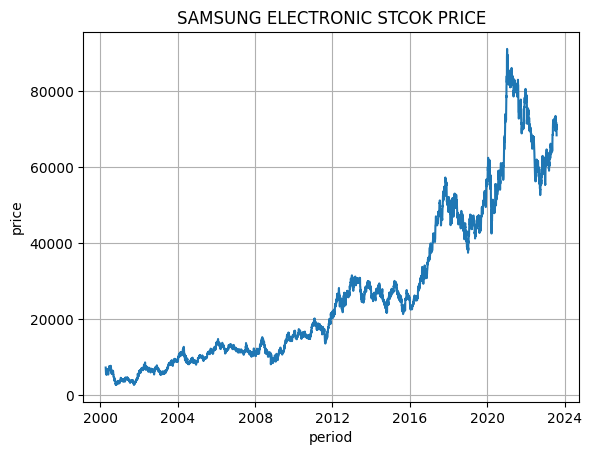

In [10]:
import matplotlib.pyplot as plt
plt.title('SAMSUNG ELECTRONIC STCOK PRICE')
plt.ylabel('price')
plt.xlabel('period')
plt.grid()

plt.plot(df['Close'], label='Close')

plt.show()

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# 데이터 준비
df['Target'] = (df['Next_Day_Direction'] == 'Up').astype(int)

# 'Target' 열을 제외한 모든 열을 features에 저장
features = df.drop(['Next_Day_Direction', 'Target'], axis=1).values
target = df['Target'].values

scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# 데이터 분할 기준 날짜 설정
train_end_date = pd.Timestamp("2021-12-31")
test_start_date = pd.Timestamp("2022-01-01")

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i : (i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 200

# 훈련 데이터 분할
train_data = df[df.index <= train_end_date]
X = train_data.drop(['Next_Day_Direction', 'Target'], axis=1)
y = train_data['Target']
X_scaled = scaler.fit_transform(X)
X_train, y_train = create_dataset(pd.DataFrame(X_scaled), y, time_steps)  # 데이터셋 생성

# 훈련 데이터를 훈련 및 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 테스트 데이터 분할
test_data = df[df.index >= test_start_date]
X_test = test_data.drop(['Next_Day_Direction', 'Target'], axis=1)
y_test = test_data['Target']
X_test_scaled = scaler.transform(X_test)
X_test, y_test = create_dataset(pd.DataFrame(X_test_scaled), y_test, time_steps)  # 데이터셋 생성


In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))  # 층 추가, 유닛 수 증가
model.add(Dropout(0.4))  # 드롭아웃 비율 증가
model.add(LSTM(100))  # 층 추가, 유닛 수 증가
model.add(Dropout(0.4))  # 드롭아웃 비율 증가
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Early Stopping
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)  # Model Checkpoint

# 모델 학습
model.fit(X_train, y_train,
          epochs=100,
          batch_size=32,
          validation_data=(X_valid, y_valid),
          callbacks=[early_stopping, checkpoint])  # 콜백 추가

Epoch 1/100
130/130 [==============================] - 8s 25ms/step - loss: 0.6952 - accuracy: 0.5116 - val_loss: 0.6949 - val_accuracy: 0.5218
Epoch 2/100
130/130 [==============================] - 2s 18ms/step - loss: 0.6916 - accuracy: 0.5259 - val_loss: 0.6968 - val_accuracy: 0.5218
Epoch 3/100
130/130 [==============================] - 2s 18ms/step - loss: 0.6920 - accuracy: 0.5240 - val_loss: 0.6926 - val_accuracy: 0.5218
Epoch 4/100
130/130 [==============================] - 3s 22ms/step - loss: 0.6926 - accuracy: 0.5259 - val_loss: 0.6924 - val_accuracy: 0.5218
Epoch 5/100
130/130 [==============================] - 2s 18ms/step - loss: 0.6922 - accuracy: 0.5322 - val_loss: 0.6933 - val_accuracy: 0.5218
Epoch 6/100
130/130 [==============================] - 2s 18ms/step - loss: 0.6918 - accuracy: 0.5303 - val_loss: 0.6926 - val_accuracy: 0.5218
Epoch 7/100
130/130 [==============================] - 2s 18ms/step - loss: 0.6916 - accuracy: 0.5315 - val_loss: 0.6924 - val_accuracy:

In [43]:
from tensorflow.keras.models import load_model

# 저장된 모델 로드
model = load_model('best_model.h5')

In [44]:
# 모델 성능 평가 및 예측
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

7/7 [==============================] - 1s 13ms/step
Accuracy: 0.5412371134020618
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        89
           1       0.54      1.00      0.70       105

    accuracy                           0.54       194
   macro avg       0.27      0.50      0.35       194
weighted avg       0.29      0.54      0.38       194



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
